In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [2]:
from arviz.utils import Numba
Numba.disable_numba()

## Coin Toss Example

In [3]:
tosses = [
    1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
    0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
    0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
    1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
    0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
    1, 1, 1, 0, 0, 0, 1, 0, 1, 0
]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


<AxesSubplot:title={'center':'theta'}>

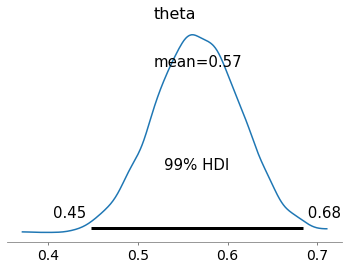

In [4]:
with pm.Model() as model:
    # define the prior
    theta = pm.Beta('theta', 2, 2)
    
    # define the likelihood
    data = pm.Bernoulli('data', theta, observed=tosses)
    
    # get the samples
    trace = pm.sample(return_inferencedata=True)
az.plot_posterior(trace, hdi_prob=0.99)

## Bayesian Univariate Linear Regression

In [5]:
x = [
   -1.64934805,  0.52925273,  1.10100092,  0.38566793, -1.56768245,
    1.26195686,  0.92613986, -0.23942803,  0.33933045,  1.14390657,
    0.65466195, -1.36229805, -0.32393554, -0.23258941,  0.17688024,
    1.60774334, -0.22801156,  1.53008133, -1.31431042, -0.27699609
] # inputs
y = [
   -3.67385666,  3.37543275,  6.25390538,  1.41569973, -2.08413872,
    6.71560158,  6.32344159,  2.40651236,  4.54217349,  6.25778739,
    4.98933806, -2.69713137,  1.45705571, -0.49772953,  1.50502898,
    7.27228263,  1.6267433 ,  6.43580518, -0.50291509,  0.65674682
] # outputs

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


array([<AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'error'}>], dtype=object)

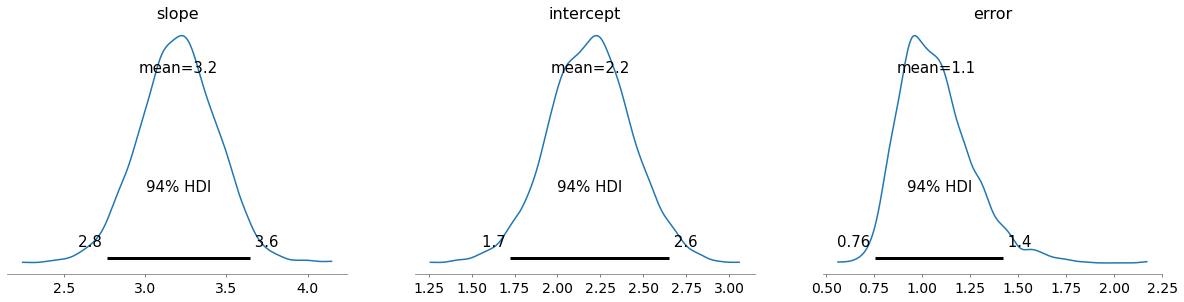

In [6]:
with pm.Model() as predictive_model:
    # define priors
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    x_ = pm.Data('features', x) # a data container, can be changed
    
    # predictions
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    # use MCMC to sample
    trace = pm.sample(return_inferencedata=True)
    
az.plot_posterior(trace)

In [7]:
x_new = np.linspace(-3, 3, 50) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

In [8]:
y_pred = posterior['observation']

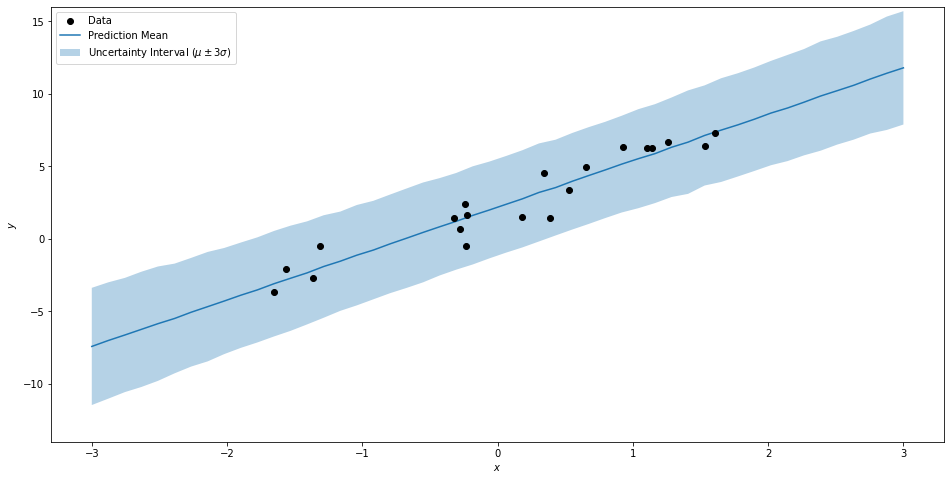

In [9]:
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-14, 16)
plt.legend(loc='upper left')

## GLM Submodule

In [10]:
with pm.Model() as simpler_model:
    pm.glm.GLM.from_formula('y ~ x', dict(x=x, y=y))
    
    trace = pm.sample()

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/sarangmdeshpande/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [11]:
import pandas as pd
df = pd.DataFrame({'x': x, 'y': y})
my_priors = {
    'Intercept': pm.Cauchy.dist(0, 10),
    'x': pm.Cauchy.dist(0, 10)
}
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', df, priors=my_priors)
    
    trace = pm.sample()

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/Users/sarangmdeshpande/opt/anaconda3/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


## Bayesian Marketing Mix Model

In [12]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

In [13]:
X

,TV,Radio,Banners
Date,,,
2018-01-07,13528.10,0.00,0.00
2018-01-14,0.00,5349.65,2218.93
2018-01-21,0.00,4235.86,2046.96
2018-01-28,0.00,3562.21,0.00
2018-02-04,0.00,0.00,2187.29
...,...,...,...
2021-10-03,0.00,0.00,1691.68
2021-10-10,11543.58,4615.35,2518.88
2021-10-17,0.00,4556.16,1919.19


In [38]:
X.describe()

,TV,Radio,Banners
count,200.000000,200.000000,200.000000
mean,2946.207650,2213.585050,1520.722550
std,4749.646908,2505.967886,870.764354
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1657.195000
50%,0.000000,0.000000,1918.990000
75%,7938.527500,4624.027500,2069.767500
max,13901.550000,7696.220000,2518.880000


In [39]:
y.describe()

count      200.000000
mean     10668.141500
std       2700.706683
min       4532.330000
25%       8396.942500
50%      10853.105000
75%      12566.995000
max      17668.340000
Name: Sales, dtype: float64

In [29]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [42]:
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_Banners, sat_Banners, coef_Banners, car_Radio, sat_Radio, coef_Radio, car_TV, sat_TV, coef_TV]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 260 seconds.
There were 702 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.321381057256608, but should be close to 0.8. Try to increase the number of tuning steps.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 531 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5724501037957055, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'coef_TV'}>,
        <AxesSubplot:title={'center':'sat_TV'}>,
        <AxesSubplot:title={'center':'car_TV'}>],
       [<AxesSubplot:title={'center':'coef_Radio'}>,
        <AxesSubplot:title={'center':'sat_Radio'}>,
        <AxesSubplot:title={'center':'car_Radio'}>],
       [<AxesSubplot:title={'center':'coef_Banners'}>,
        <AxesSubplot:title={'center':'sat_Banners'}>,
        <AxesSubplot:title={'center':'car_Banners'}>],
       [<AxesSubplot:title={'center':'base'}>,
        <AxesSubplot:title={'center':'noise'}>, <AxesSubplot:>]],
      dtype=object)

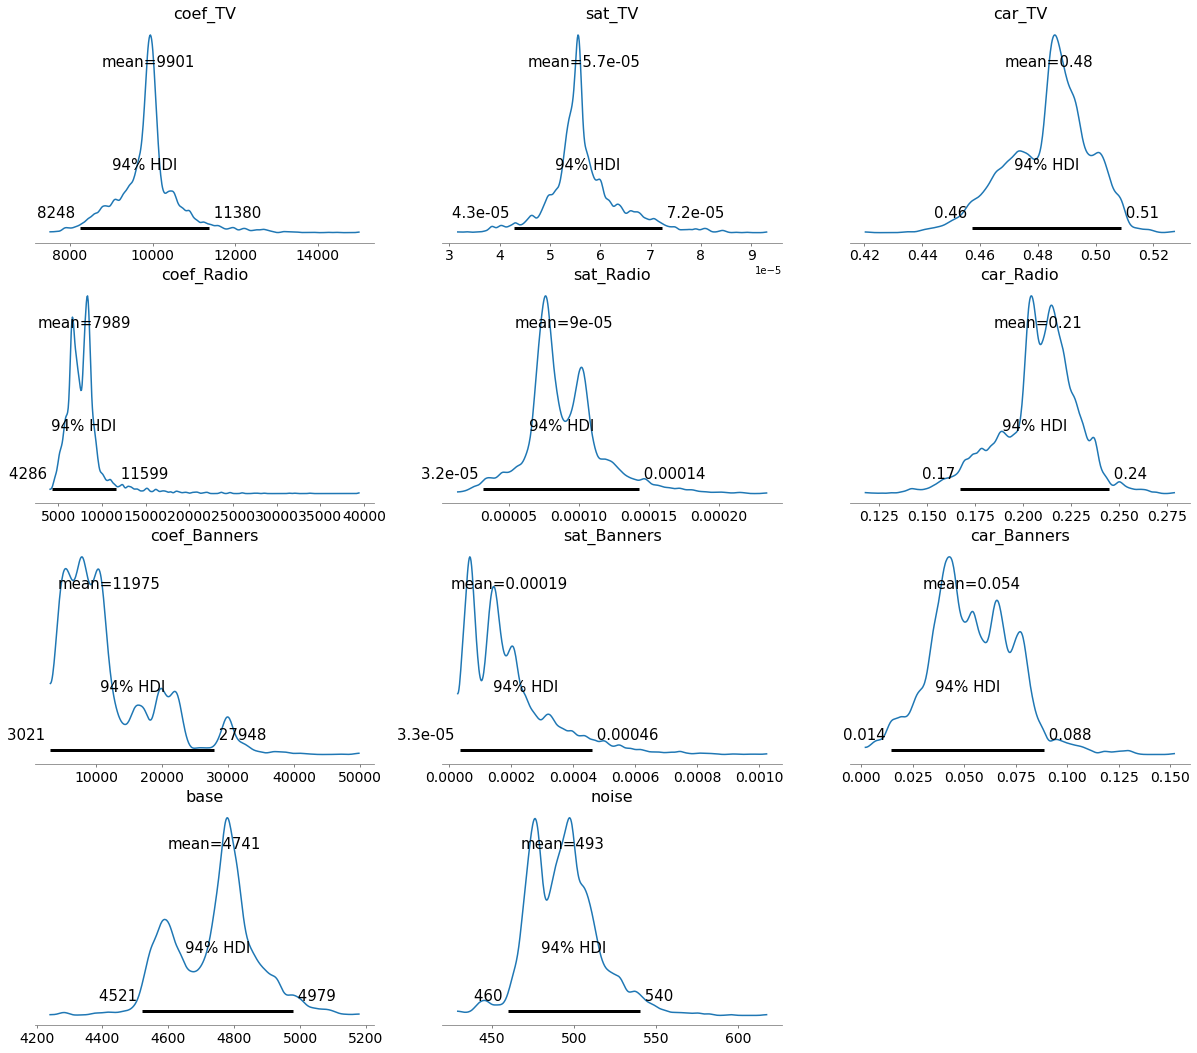

In [43]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='coef_TV', ylabel='sat_TV'>, <AxesSubplot:>]],
      dtype=object)

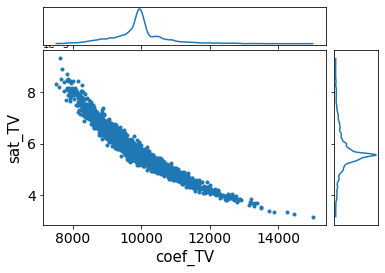

In [44]:
az.plot_pair(
    trace,
    var_names=['coef_TV', 'sat_TV'],
    marginals=True
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='car_TV', ylabel='sat_TV'>, <AxesSubplot:>]],
      dtype=object)

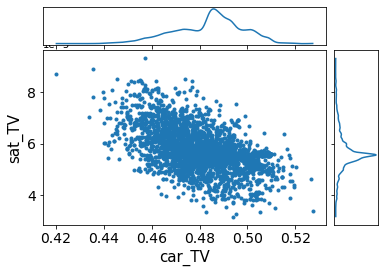

In [45]:
az.plot_pair(
    trace,
    var_names=['car_TV', 'sat_TV'],
    marginals=True
)

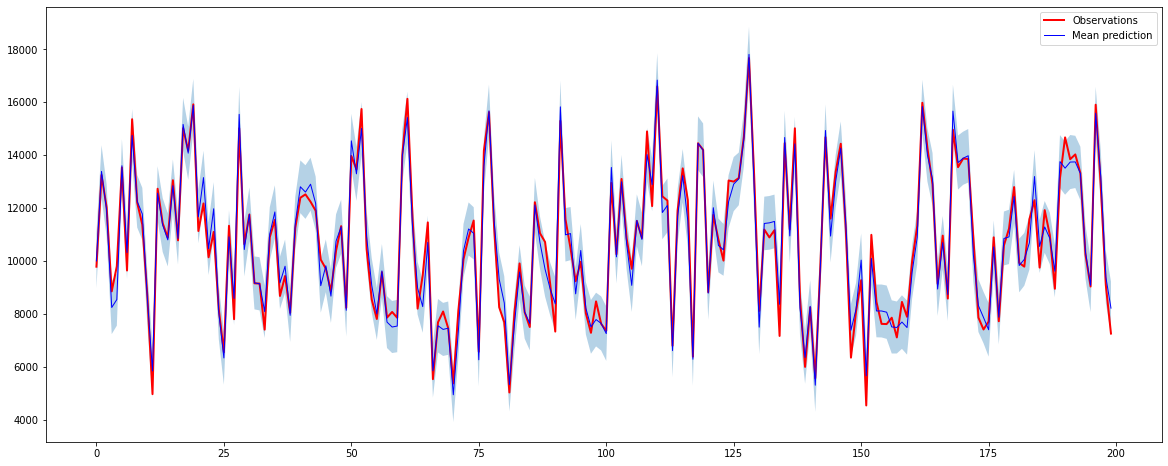

In [46]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

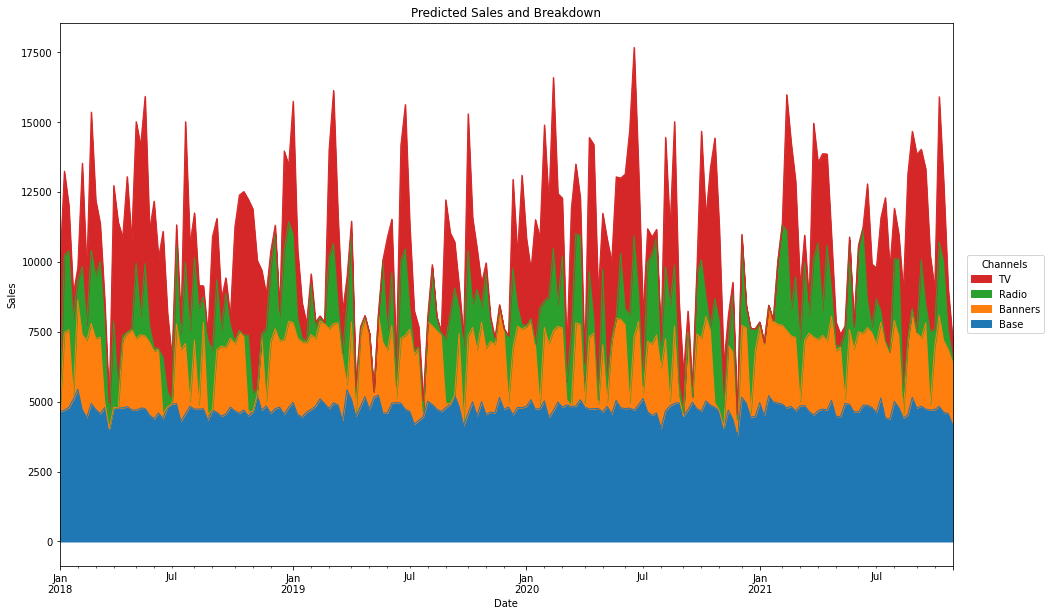

In [47]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )
channels = ['Banners', 'Radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)